In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
import os

root = "D:\Code\PythonProject\Advanced\multi_task_ct"

print(f"📁 Listing folder: {root}\n")

# Liệt kê tầng 1
for item in sorted(os.listdir(root)):
    path1 = os.path.join(root, item)
    print(f"├── {item}")

    # chỉ in tối đa 2 tầng
    if os.path.isdir(path1):
        try:
            sub_items = sorted(os.listdir(path1))
        except PermissionError:
            print("│     [Permission denied]")
            continue

        # Nếu thư mục rỗng
        if len(sub_items) == 0:
            print("│     (empty)")
            continue

        # In tầng 2
        for sub in sub_items:
            print(f"│   ├── {sub}")
    else:
        print(f"│   (file)")

📁 Listing folder: D:\Code\PythonProject\Advanced\multi_task_ct

├── checkpoints
│   ├── unet_multitask_best.pth
│   ├── unet_multitask_last.pth
│   ├── unet_seg_best.pth
│   ├── unet_seg_last.pth
├── data
│   ├── processed
│   ├── raw
├── logs
│   ├── unet_multitask_log.csv
│   ├── unet_seg_log.csv
├── notebooks
│   ├── 000_setup_all.ipynb
│   ├── 00_setup_all.ipynb
│   ├── 00_setup_and_extract.ipynb
│   ├── 01_covid_lung_infection_info.ipynb
│   ├── 02_covid19_normal.ipynb
│   ├── 03_preprocess_dataset.ipynb
│   ├── 05_check_test_model.ipynb
├── output
│     (empty)
├── src
│   ├── .ipynb_checkpoints
│   ├── __init__.py
│   ├── __pycache__
│   ├── data
│   ├── losses
│   ├── models
│   ├── preprocess
│   ├── pretrained
│   ├── train
│   ├── utils
├── training_curves_unet_seg.png
│   (file)


In [3]:
import os

root = "/content/drive/MyDrive/multi_task_ct/data/processed/covid_normal"

for item in sorted(os.listdir(root)):
    print("├──", item)
    path1 = os.path.join(root, item)
    if os.path.isdir(path1):
        for sub in os.listdir(path1):
            print("│   ├──", sub)
    else:
        print("│   (file)")

├── images
│   ├── img
│   ├── img_roi
├── masks
│   ├── lesion
│   ├── lung
├── meta.csv
│   (file)
├── splits
│   ├── train.txt
│   ├── val.txt
│   ├── test.txt


## 1. Thực nghiệm với U-Net phân đoạn

### 1.1 Setup chung

In [9]:
import os
import sys
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120

# ----- Project root -----
PROJECT_ROOT = r"D:\Code\PythonProject\Advanced\multi_task_ct"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)

# ----- Import từ src -----
from src.models.unet import UNet
from src.data.dataset_ct import LungCTMultiTaskDataset
from src.utils.metrics import dice_coefficient, iou_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# ----- Đường dẫn dữ liệu processed/covid_normal -----
DATA_ROOT = os.path.join(PROJECT_ROOT, "data", "processed", "covid_normal")
META_CSV  = os.path.join(DATA_ROOT, "meta.csv")
SPLIT_DIR = os.path.join(DATA_ROOT, "splits")   # do make_splits.py tạo

TRAIN_TXT = os.path.join(SPLIT_DIR, "train.txt")
VAL_TXT   = os.path.join(SPLIT_DIR, "val.txt")
TEST_TXT  = os.path.join(SPLIT_DIR, "test.txt")

print("DATA_ROOT:", DATA_ROOT)
print("META_CSV :", META_CSV)
print("SPLIT_DIR:", SPLIT_DIR)

# ----- Checkpoint U-Net segmentation -----
CKPT_SEG_BEST = os.path.join(PROJECT_ROOT, "checkpoints", "unet_seg_best.pth")
print("CKPT_SEG_BEST:", CKPT_SEG_BEST)

PROJECT_ROOT: D:\Code\PythonProject\Advanced\multi_task_ct
Device: cuda
DATA_ROOT: D:\Code\PythonProject\Advanced\multi_task_ct\data\processed\covid_normal
META_CSV : D:\Code\PythonProject\Advanced\multi_task_ct\data\processed\covid_normal\meta.csv
SPLIT_DIR: D:\Code\PythonProject\Advanced\multi_task_ct\data\processed\covid_normal\splits
CKPT_SEG_BEST: D:\Code\PythonProject\Advanced\multi_task_ct\checkpoints\unet_seg_best.pth


### 1.2 Dataset & DataLoader cho test

In [10]:
BATCH_SIZE = 4

test_dataset_seg = LungCTMultiTaskDataset(
    data_root=DATA_ROOT,
    split_txt=TEST_TXT,
    meta_csv=META_CSV,
    use_roi=True,    # dùng images/img_roi làm input
)

test_loader_seg = DataLoader(
    test_dataset_seg,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

print("Số sample TEST (seg):", len(test_dataset_seg))
print("Ví dụ 3 sample đầu:")

for i in range(min(3, len(test_dataset_seg))):
    s = test_dataset_seg[i]
    print(
        f"  [{i}] id={s['id']}, "
        f"image={tuple(s['image'].shape)}, "
        f"mask={tuple(s['mask'].shape)}, "
        f"label={int(s['label'])}"
    )

Số sample TEST (seg): 1758
Ví dụ 3 sample đầu:
  [0] id=p57_z004, image=(1, 256, 256), mask=(1, 256, 256), label=1
  [1] id=p57_z005, image=(1, 256, 256), mask=(1, 256, 256), label=1
  [2] id=p57_z006, image=(1, 256, 256), mask=(1, 256, 256), label=1


### 1.3 Load model & evaluate Dice / IoU trên test

In [11]:
def load_unet_segmentation(checkpoint_path):
    model = UNet(in_channels=1, out_channels=1)
    ckpt = torch.load(checkpoint_path, map_location=DEVICE)

    # train_unet.py lưu dạng dict có "model_state"
    if isinstance(ckpt, dict) and "model_state" in ckpt:
        state_dict = ckpt["model_state"]
    else:
        state_dict = ckpt

    model.load_state_dict(state_dict)
    model.to(DEVICE)
    model.eval()
    return model


def evaluate_unet_on_test(model, loader):
    all_dice = []
    all_iou  = []

    with torch.no_grad():
        for batch in loader:
            imgs  = batch["image"].to(DEVICE)  # [B,1,H,W]
            masks = batch["mask"].to(DEVICE)   # [B,1,H,W], 0/1

            preds = model(imgs)                # [B,1,H,W], prob 0-1 (đã sigmoid)

            # metrics của bạn tự threshold & mean, trả về float
            dice = dice_coefficient(preds, masks)
            iou  = iou_score(preds, masks)

            all_dice.append(dice)
            all_iou.append(iou)

    dice_mean = float(np.mean(all_dice))
    iou_mean  = float(np.mean(all_iou))

    print(f"[UNet-SEG] Test Dice = {dice_mean:.4f}, IoU = {iou_mean:.4f}")
    return dice_mean, iou_mean


unet_seg = load_unet_segmentation(CKPT_SEG_BEST)
dice_test, iou_test = evaluate_unet_on_test(unet_seg, test_loader_seg)

[UNet-SEG] Test Dice = 0.7610, IoU = 0.7067


### 1.4 Lấy danh sách case_id xuất hiện trong test

In [12]:
import csv
import os

# đọc meta.csv thành dict: slice_id -> row
meta_dict = {}
with open(META_CSV, "r", newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        sid = os.path.splitext(os.path.basename(row["img"]))[0]  # p57_z004
        meta_dict[sid] = row

# đọc test.txt
test_ids = []
with open(TEST_TXT, "r") as f:
    for line in f:
        sid = line.strip()
        if sid:
            test_ids.append(sid)

print("Tổng số slice trong test:", len(test_ids))

# lấy các case_id tương ứng
case_ids_in_test = []
for sid in test_ids:
    row = meta_dict.get(sid)
    if row is None:
        continue
    cid = row["case_id"]
    if cid not in case_ids_in_test:
        case_ids_in_test.append(cid)

print("Số case trong test:", len(case_ids_in_test))
print("Danh sách case_id trong test:")
print(case_ids_in_test)


Tổng số slice trong test: 1758
Số case trong test: 46
Danh sách case_id trong test:
['p57', '49', '15', 'p139', '59', 'p24', '109', 'p121', 'p91', '40', '47', 'p147', '5', '55', '93', '37', 'p68', 'p39', '156', '39', '86', 'p40', 'p103', 'p98', '103', 'p6', '7', '92', 'p5', 'p113', '133', 'p77', 'p69', 'p145', 'p115', 'p116', '81', 'p142', '157', 'p14', 'p31', 'p72', 'p82', 'p96', 'p111', 'p19']


### 1.5 Chọn 1 case trong test & hiển thị các lát có lesion

Case p57 có 5 lát có lesion trong TEST.


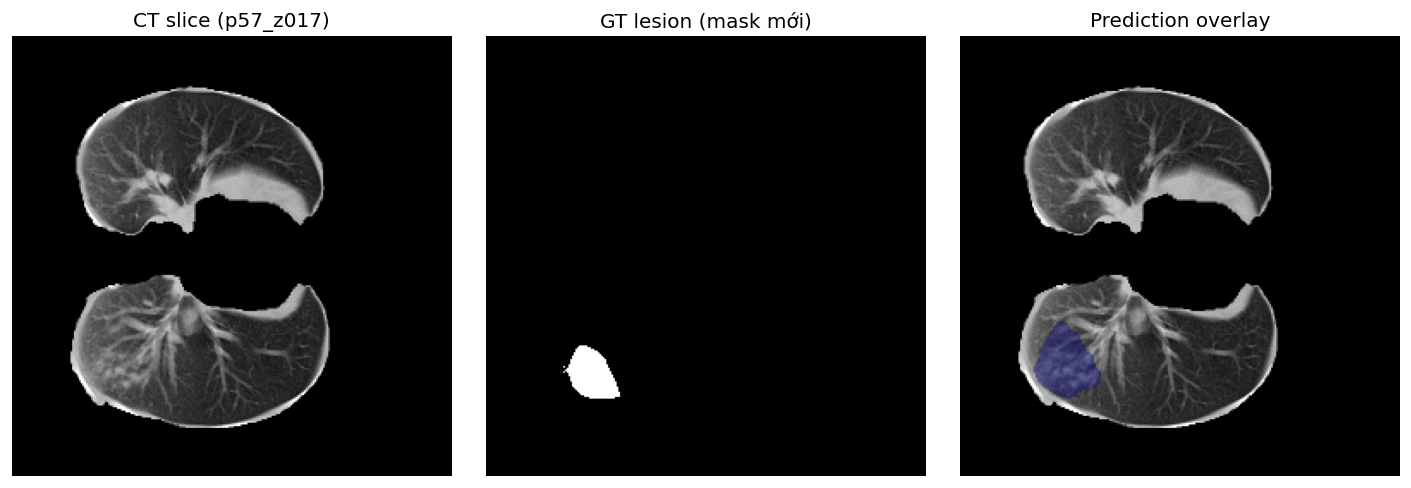

Saved: D:\Code\PythonProject\Advanced\multi_task_ct\output\unet_seg_p57_p57_z017.png


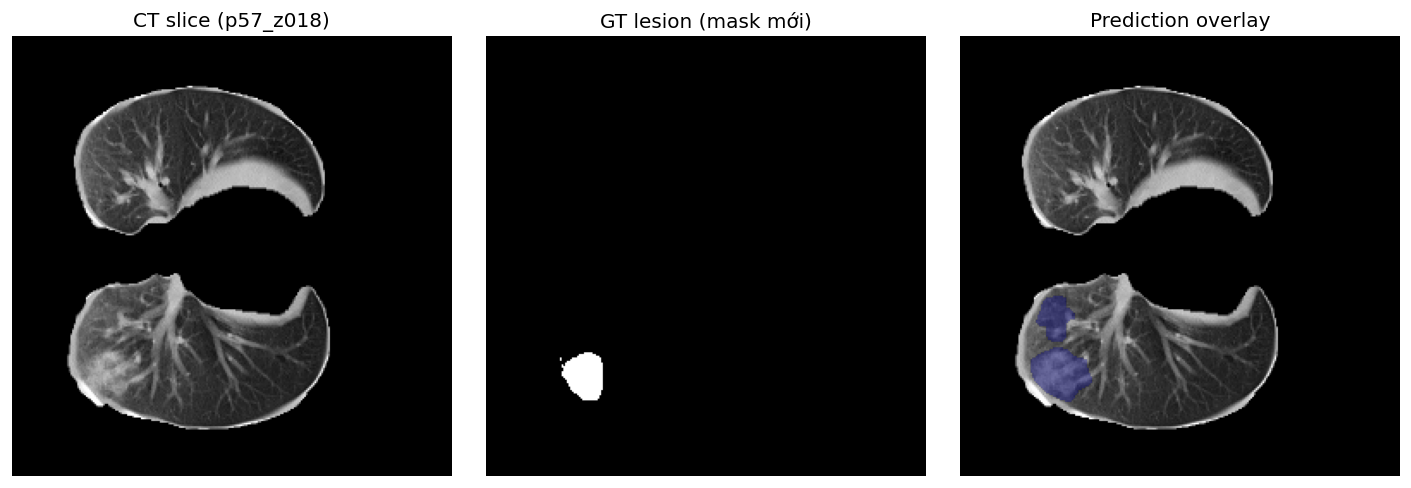

Saved: D:\Code\PythonProject\Advanced\multi_task_ct\output\unet_seg_p57_p57_z018.png


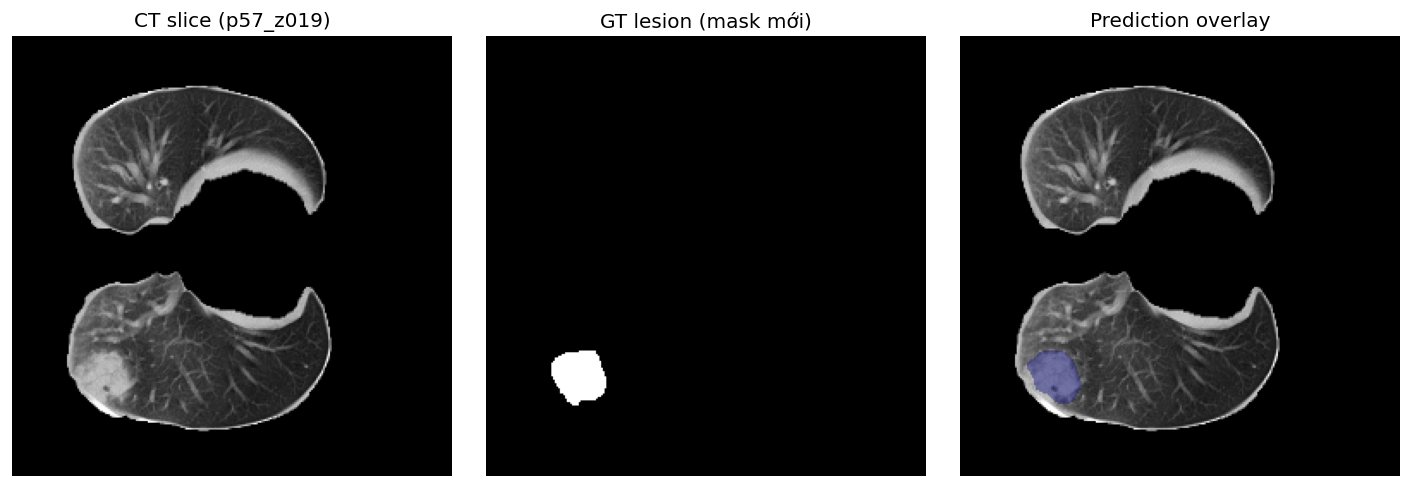

Saved: D:\Code\PythonProject\Advanced\multi_task_ct\output\unet_seg_p57_p57_z019.png


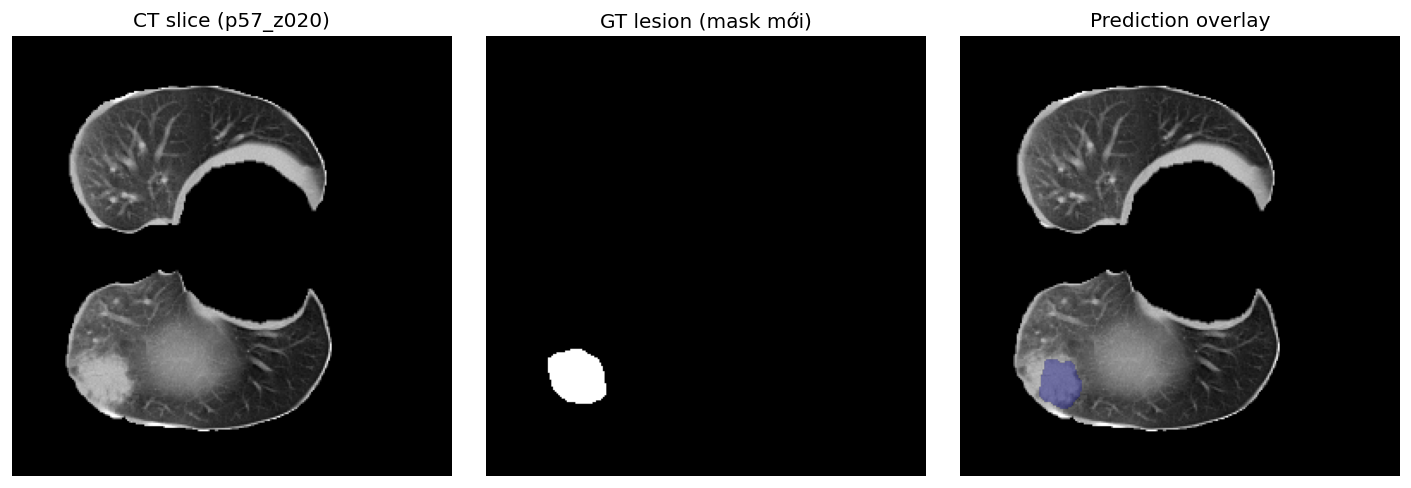

Saved: D:\Code\PythonProject\Advanced\multi_task_ct\output\unet_seg_p57_p57_z020.png


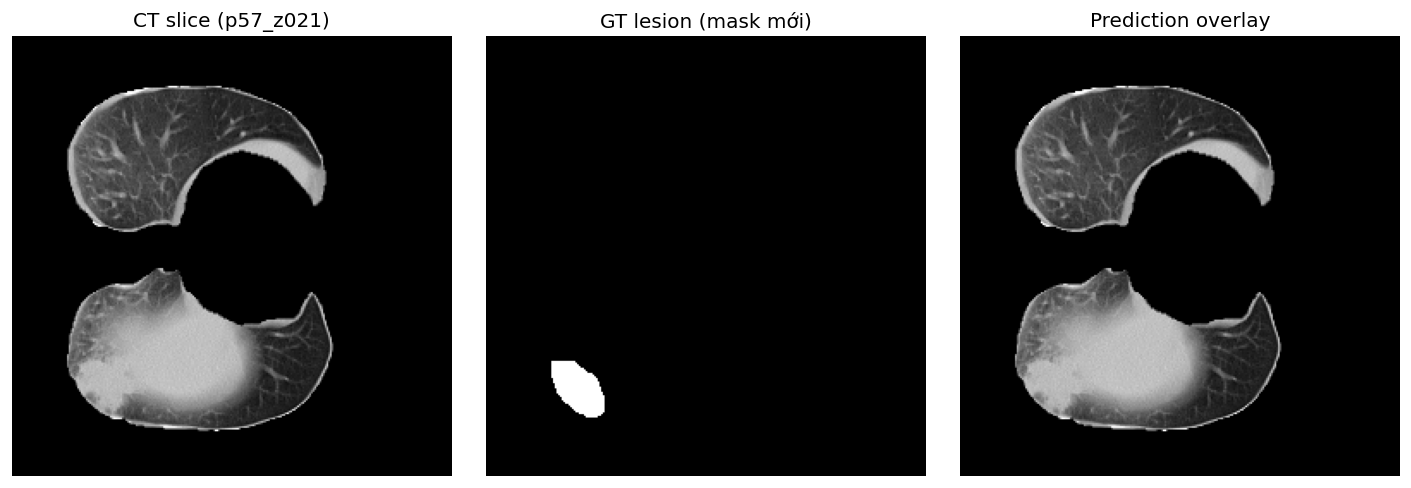

Saved: D:\Code\PythonProject\Advanced\multi_task_ct\output\unet_seg_p57_p57_z021.png


In [14]:
# ============================================================
# CELL 5 — HIỂN THỊ KẾT QUẢ SEG CHO 1 CASE TRONG TEST (ĐÃ SỬA)
# ============================================================
import numpy as np
import os

# === CHỌN CASE Ở ĐÂY ===
TARGET_CASE_ID = "p57"   # ví dụ: 'p57', 'p100', '58', ... phải nằm trong case_ids_in_test
MAX_SLICES_SHOW = 6      # tối đa bao nhiêu lát muốn xem

def get_indices_for_case_with_lesion(dataset, case_id):
    """Trả về các index trong dataset thuộc case_id & has_lesion=1."""
    idxs = []
    for i, sid in enumerate(dataset.slice_ids):
        row = dataset.meta[sid]
        if row["case_id"] != case_id:
            continue
        # cột has_lesion: '0' / '1'
        if row.get("has_lesion", "0") in ["1", "True", "true"]:
            idxs.append(i)
    return idxs

case_indices = get_indices_for_case_with_lesion(test_dataset_seg, TARGET_CASE_ID)
print(f"Case {TARGET_CASE_ID} có {len(case_indices)} lát có lesion trong TEST.")

if len(case_indices) == 0:
    print("⚠ Case này không có lát lesion trong test. Đổi TARGET_CASE_ID sang case khác.")
else:
    SAVE_DIR = os.path.join(PROJECT_ROOT, "output")
    os.makedirs(SAVE_DIR, exist_ok=True)

    unet_seg.eval()
    shown = 0

    for idx in case_indices:
        if shown >= MAX_SLICES_SHOW:
            break

        sample = test_dataset_seg[idx]
        sid    = sample["id"]                      # ví dụ: 'p57_z004'

        # sample["image"]: [1, H, W]
        img_chw = sample["image"]                  # tensor [1,H,W]
        mask_chw = sample["mask"]                  # tensor [1,H,W]

        # đưa vào model: thêm batch dim -> [1,1,H,W]
        img_t  = img_chw.unsqueeze(0).to(DEVICE)

        # ground truth mask 2D: [H,W]
        gt = mask_chw.squeeze(0).numpy()          # hoặc mask_chw[0].numpy()

        with torch.no_grad():
            pred_t = unet_seg(img_t)              # [1,1,H,W]
        pred_np  = pred_t.cpu().numpy()[0, 0]     # [H,W]
        pred_bin = (pred_np > 0.5).astype(np.float32)

        # ảnh CT 2D: [H,W]
        img_np = img_chw.squeeze(0).numpy()       # hoặc img_chw[0].numpy()

        plt.figure(figsize=(12, 4))

        # 1) CT slice
        plt.subplot(1, 3, 1)
        plt.imshow(img_np, cmap="gray")
        plt.title(f"CT slice ({sid})")
        plt.axis("off")

        # 2) GT lesion (mask mới)
        plt.subplot(1, 3, 2)
        plt.imshow(gt, cmap="gray")
        plt.title("GT lesion (mask mới)")
        plt.axis("off")

        # 3) Prediction overlay
        plt.subplot(1, 3, 3)
        plt.imshow(img_np, cmap="gray")
        plt.imshow(
            np.ma.masked_where(pred_bin == 0, pred_bin),
            cmap="jet", alpha=0.4
        )
        plt.title("Prediction overlay")
        plt.axis("off")

        plt.tight_layout()
        out_path = os.path.join(SAVE_DIR, f"unet_seg_{TARGET_CASE_ID}_{sid}.png")
        plt.savefig(out_path, dpi=200)
        plt.show()
        print("Saved:", out_path)

        shown += 1

### 1.6 Vẽ loss và dice

Log path: D:\Code\PythonProject\Advanced\multi_task_ct\logs\unet_seg_log.csv
Các cột trong log: ['epoch', 'train_loss', 'train_dice', 'train_iou', 'val_loss', 'val_dice', 'val_iou', 'lr']
Số epoch: 21
Saved figure to: D:\Code\PythonProject\Advanced\multi_task_ct\training_curves_unet_seg_from_log.png


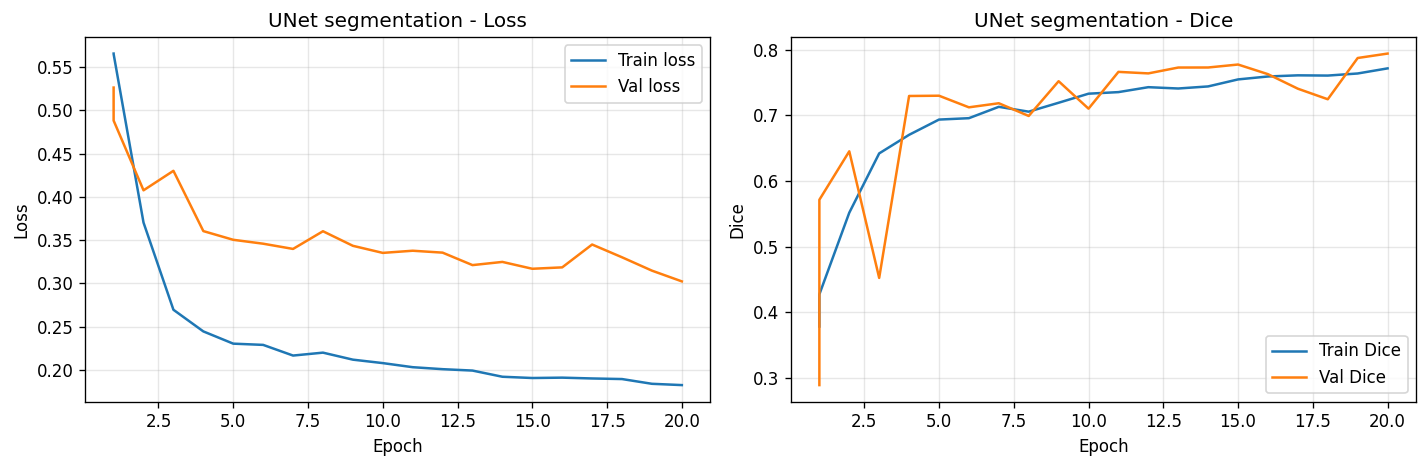

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt

LOG_PATH = r"D:\Code\PythonProject\Advanced\multi_task_ct\logs\unet_seg_log.csv"
print("Log path:", LOG_PATH)

df = pd.read_csv(LOG_PATH)
print("Các cột trong log:", df.columns.tolist())
print("Số epoch:", len(df))

epochs = df["epoch"]

plt.figure(figsize=(12, 4))

# ----- Loss -----
plt.subplot(1, 2, 1)
plt.plot(epochs, df["train_loss"], label="Train loss")
plt.plot(epochs, df["val_loss"],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("UNet segmentation - Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# ----- Dice -----
plt.subplot(1, 2, 2)
plt.plot(epochs, df["train_dice"], label="Train Dice")
plt.plot(epochs, df["val_dice"],   label="Val Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title("UNet segmentation - Dice")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

# Nếu muốn lưu hình:
out_png = os.path.join(
    r"D:\Code\PythonProject\Advanced\multi_task_ct",
    "training_curves_unet_seg_from_log.png"
)
plt.savefig(out_png, dpi=200)
print("Saved figure to:", out_png)

plt.show()


## 2, Thực nghiệm với U-Net Multi task

### 2.1 Set up

In [16]:
import os
import sys
import csv
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Nếu notebook nằm trong thư mục "notebooks", PROJECT_ROOT là thư mục cha
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, ".."))
print("PROJECT_ROOT:", PROJECT_ROOT)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data.dataset_ct import LungCTMultiTaskDataset
from src.models.unet import UNetMultiTask
from src.losses.losses import MultiTaskLoss
from src.utils.metrics import dice_coefficient, iou_score, classification_metrics

# ----- đường dẫn dữ liệu processed -----
data_root = os.path.join(PROJECT_ROOT, "data", "processed", "covid_normal")
meta_csv = os.path.join(data_root, "meta.csv")

# Ưu tiên dùng splits_by_case nếu có
splits_dir_case   = os.path.join(data_root, "splits_by_case")
splits_dir_simple = os.path.join(data_root, "splits")
if os.path.isdir(splits_dir_case):
    splits_dir = splits_dir_case
else:
    splits_dir = splits_dir_simple

train_txt = os.path.join(splits_dir, "train.txt")
val_txt   = os.path.join(splits_dir, "val.txt")
test_txt  = os.path.join(splits_dir, "test.txt")

print("Splits dir:", splits_dir)
print("Test txt  :", test_txt)

# ----- tạo dataset & dataloader test -----
test_set = LungCTMultiTaskDataset(
    data_root=data_root,
    split_txt=test_txt,
    meta_csv=meta_csv,
    use_roi=True,   # dùng ảnh ROI (phổi)
)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=2)

print("Số sample test:", len(test_set))
print("Ví dụ 5 slice_id đầu:", test_set.slice_ids[:5])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ----- đường dẫn checkpoint + log -----
ckpt_path = os.path.join(PROJECT_ROOT, "checkpoints", "unet_multitask_best.pth")
log_csv   = os.path.join(PROJECT_ROOT, "logs", "unet_multitask_log.csv")
print("Best ckpt:", ckpt_path)
print("Log CSV  :", log_csv)


PROJECT_ROOT: d:\Code\PythonProject\Advanced\multi_task_ct
Splits dir: d:\Code\PythonProject\Advanced\multi_task_ct\data\processed\covid_normal\splits
Test txt  : d:\Code\PythonProject\Advanced\multi_task_ct\data\processed\covid_normal\splits\test.txt
Số sample test: 1758
Ví dụ 5 slice_id đầu: ['p57_z004', 'p57_z005', 'p57_z006', 'p57_z007', 'p57_z008']
Device: cuda
Best ckpt: d:\Code\PythonProject\Advanced\multi_task_ct\checkpoints\unet_multitask_best.pth
Log CSV  : d:\Code\PythonProject\Advanced\multi_task_ct\logs\unet_multitask_log.csv


### 2.2 Vẽ Loss, Dice, Accuracy (train / val) từ unet_multitask_log.csv

   epoch  train_loss  train_dice  train_iou  train_acc  val_loss  val_dice  \
0      1    0.777244    0.339639   0.282845   0.913525  0.571277  0.402850   
1      1    0.834813    0.319748   0.264920   0.908537  0.635252  0.388992   
2      2    0.628652    0.410843   0.350929   0.947201  0.662491  0.513068   
3      3    0.547125    0.451721   0.390114   0.953021  0.491557  0.574539   
4      4    0.510578    0.499122   0.437202   0.962583  0.589626  0.574338   

    val_iou   val_acc      lr  
0  0.343365  0.965771  0.0001  
1  0.329501  0.955931  0.0001  
2  0.451196  0.914496  0.0001  
3  0.512853  0.967849  0.0001  
4  0.511450  0.938331  0.0001  


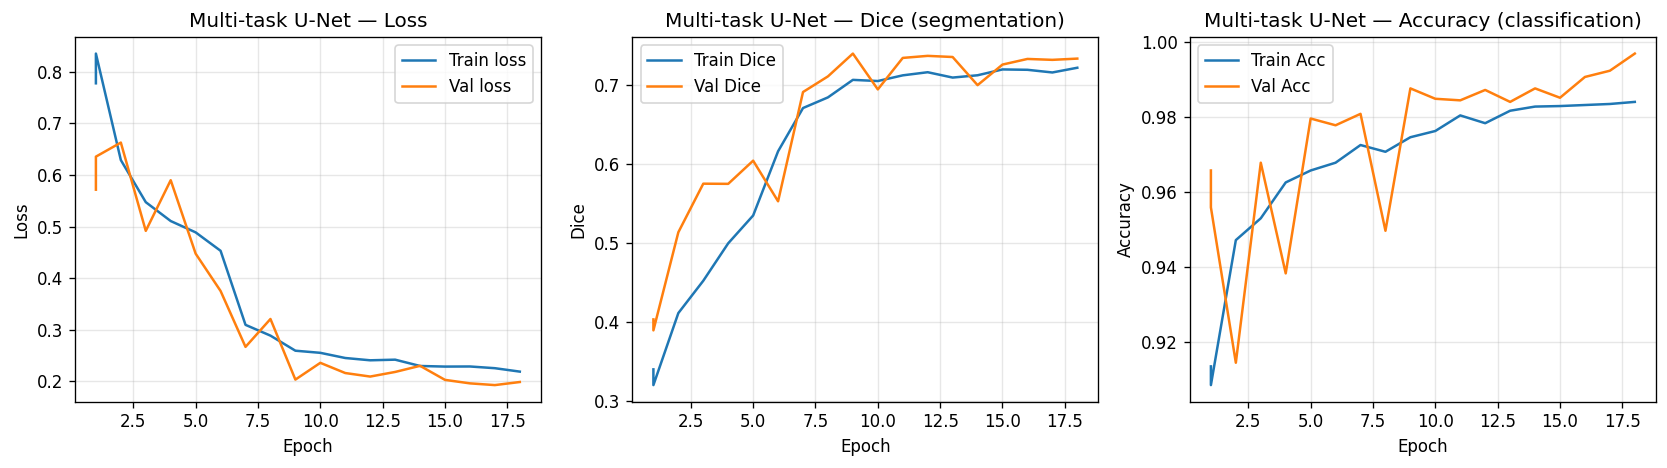

In [17]:
import pandas as pd

df = pd.read_csv(log_csv)
print(df.head())

epochs = df["epoch"].values

train_loss = df["train_loss"].astype(float).values
val_loss   = df["val_loss"].astype(float).values

train_dice = df["train_dice"].astype(float).values
val_dice   = df["val_dice"].astype(float).values

train_acc  = df["train_acc"].astype(float).values
val_acc    = df["val_acc"].astype(float).values

plt.figure(figsize=(14, 4))

# ---- Loss ----
plt.subplot(1, 3, 1)
plt.plot(epochs, train_loss, label="Train loss")
plt.plot(epochs, val_loss,   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Multi-task U-Net — Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# ---- Dice ----
plt.subplot(1, 3, 2)
plt.plot(epochs, train_dice, label="Train Dice")
plt.plot(epochs, val_dice,   label="Val Dice")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title("Multi-task U-Net — Dice (segmentation)")
plt.legend()
plt.grid(True, alpha=0.3)

# ---- Accuracy ----
plt.subplot(1, 3, 3)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc,   label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Multi-task U-Net — Accuracy (classification)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 2.3 Load checkpoint tốt nhất và đánh giá trên tập test

In [18]:
@torch.no_grad()
def eval_multitask(model, loader, criterion, device, phase="Test"):
    model.eval()
    total_loss = 0.0
    total_dice = 0.0
    total_iou  = 0.0
    total_acc  = 0.0
    n_batches  = len(loader)

    for batch in loader:
        imgs   = batch["image"].to(device)   # [B,1,H,W]
        masks  = batch["mask"].to(device)    # [B,1,H,W]
        labels = batch["label"].to(device)   # [B]

        pred_seg, pred_cls = model(imgs)
        loss, _, _ = criterion(pred_seg, masks, pred_cls, labels)

        total_loss += loss.item()
        total_dice += dice_coefficient(pred_seg, masks)
        total_iou  += iou_score(pred_seg, masks)
        total_acc  += classification_metrics(pred_cls, labels)

    return (total_loss / n_batches,
            total_dice / n_batches,
            total_iou / n_batches,
            total_acc / n_batches)


# ----- khởi tạo model + loss + load best checkpoint -----
model = UNetMultiTask(
    in_channels=1,
    num_seg_classes=1,
    num_cls_classes=2,
).to(device)

print("Số tham số model:", sum(p.numel() for p in model.parameters()))

ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"])
print("Loaded checkpoint epoch:", ckpt.get("epoch", "N/A"))

criterion = MultiTaskLoss(
    w_seg=1.0,
    w_cls=1.0,
    dice_weight=0.5,
    bce_weight=0.5,
)

# ----- đánh giá trên test -----
te_loss, te_dice, te_iou, te_acc = eval_multitask(
    model, test_loader, criterion, device, phase="Test"
)

print(f"[UNet-MULTI] Test loss = {te_loss:.4f}")
print(f"[UNet-MULTI] Test Dice (seg) = {te_dice:.4f}")
print(f"[UNet-MULTI] Test IoU  (seg) = {te_iou:.4f}")
print(f"[UNet-MULTI] Test Acc  (cls) = {te_acc:.4f}")

Số tham số model: 31173827
Loaded checkpoint epoch: 9
[UNet-MULTI] Test loss = 0.2131
[UNet-MULTI] Test Dice (seg) = 0.7445
[UNet-MULTI] Test IoU  (seg) = 0.6911
[UNet-MULTI] Test Acc  (cls) = 0.9824


### 2.4 Thống kê các case trong test

In [19]:
from collections import defaultdict

case_to_slices = defaultdict(list)
for sid in test_set.slice_ids:
    row = test_set.meta[sid]          # row từ meta.csv (dict)
    cid = row["case_id"]
    case_to_slices[cid].append(sid)

print("Số case trong test:", len(case_to_slices))
for cid, sids in case_to_slices.items():
    print(f"  Case {cid}: {len(sids)} slices (ví dụ: {sids[:5]})")

Số case trong test: 46
  Case p57: 24 slices (ví dụ: ['p57_z004', 'p57_z005', 'p57_z006', 'p57_z007', 'p57_z008'])
  Case 49: 40 slices (ví dụ: ['49_z008', '49_z009', '49_z010', '49_z011', '49_z012'])
  Case 15: 44 slices (ví dụ: ['15_z010', '15_z011', '15_z012', '15_z013', '15_z014'])
  Case p139: 35 slices (ví dụ: ['p139_z004', 'p139_z005', 'p139_z006', 'p139_z007', 'p139_z008'])
  Case 59: 46 slices (ví dụ: ['59_z007', '59_z008', '59_z009', '59_z010', '59_z011'])
  Case p24: 32 slices (ví dụ: ['p24_z007', 'p24_z008', 'p24_z009', 'p24_z010', 'p24_z011'])
  Case 109: 26 slices (ví dụ: ['109_z004', '109_z005', '109_z006', '109_z007', '109_z008'])
  Case p121: 72 slices (ví dụ: ['p121_z007', 'p121_z008', 'p121_z009', 'p121_z010', 'p121_z011'])
  Case p91: 30 slices (ví dụ: ['p91_z005', 'p91_z006', 'p91_z007', 'p91_z008', 'p91_z009'])
  Case 40: 47 slices (ví dụ: ['40_z007', '40_z008', '40_z009', '40_z010', '40_z011'])
  Case 47: 43 slices (ví dụ: ['47_z003', '47_z004', '47_z005', '47_z0

### 2.5 Visualize multi-task cho 1 case: CT + GT lesion + Pred lesion + nhãn class

Case p147 có 42 slices trong test.
Một vài slice đầu: ['p147_z002', 'p147_z003', 'p147_z004', 'p147_z005', 'p147_z006', 'p147_z007', 'p147_z008', 'p147_z009', 'p147_z010', 'p147_z011']
Các slice sẽ vẽ: ['p147_z021', 'p147_z022', 'p147_z023', 'p147_z024', 'p147_z025']


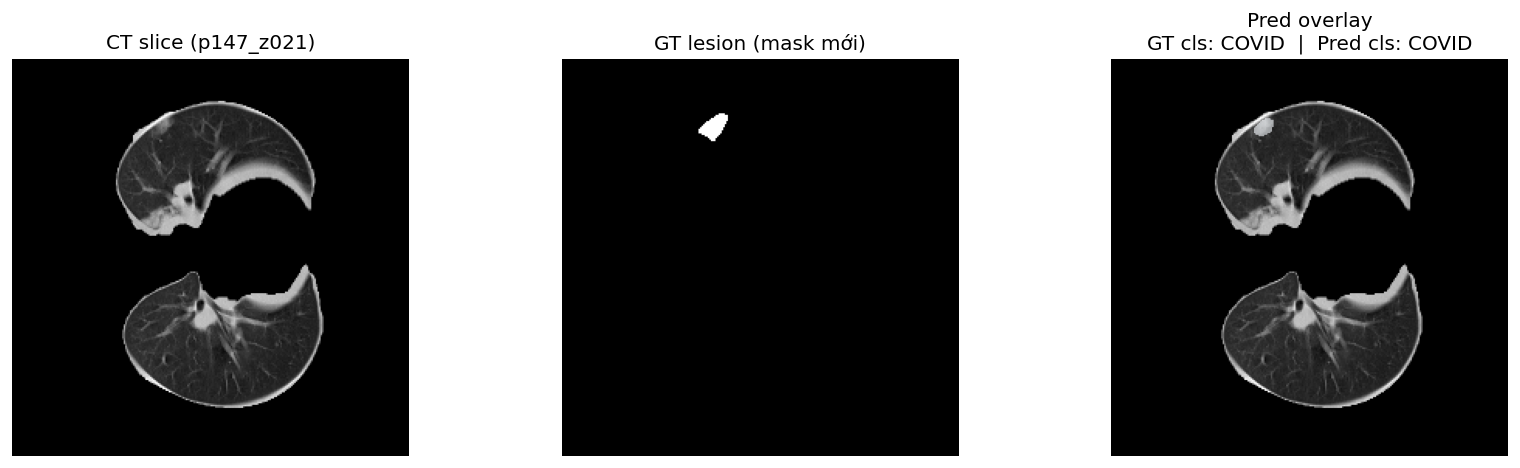

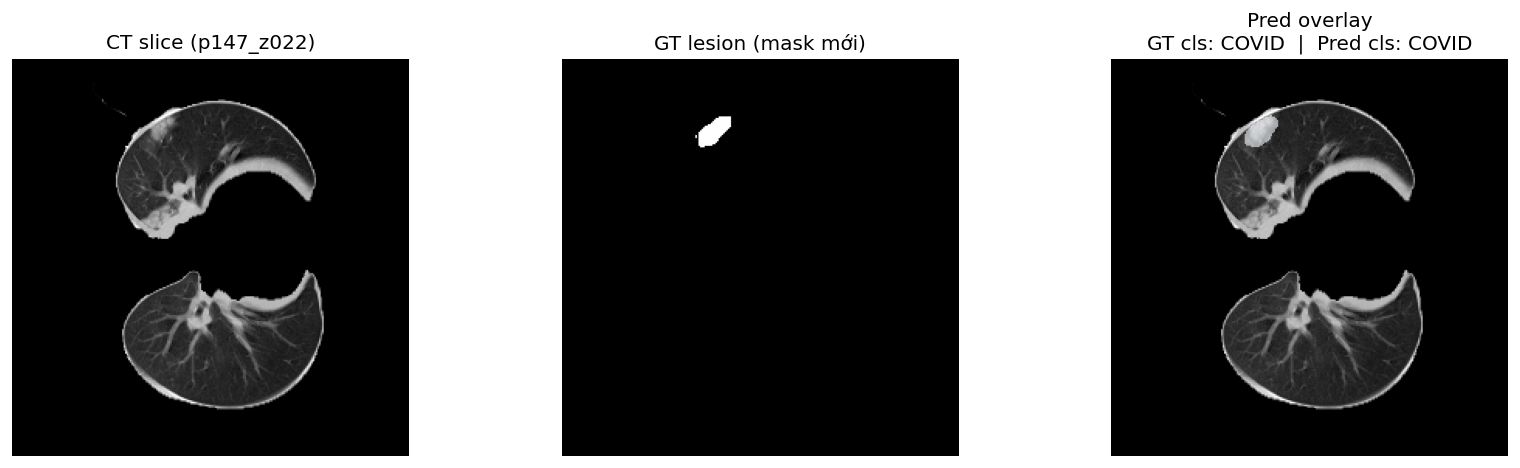

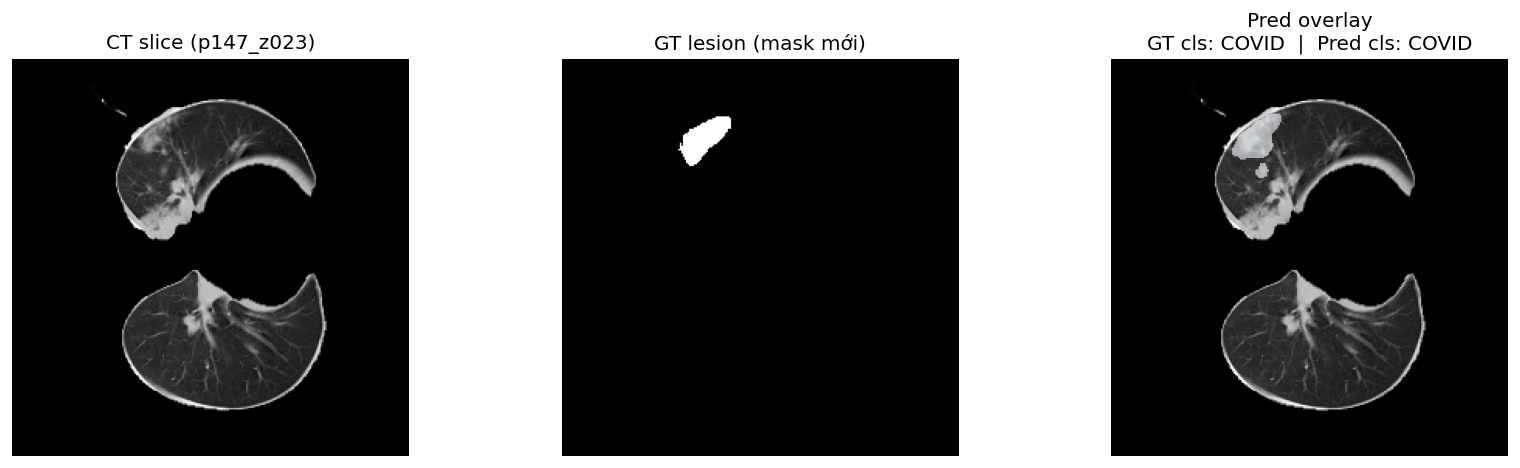

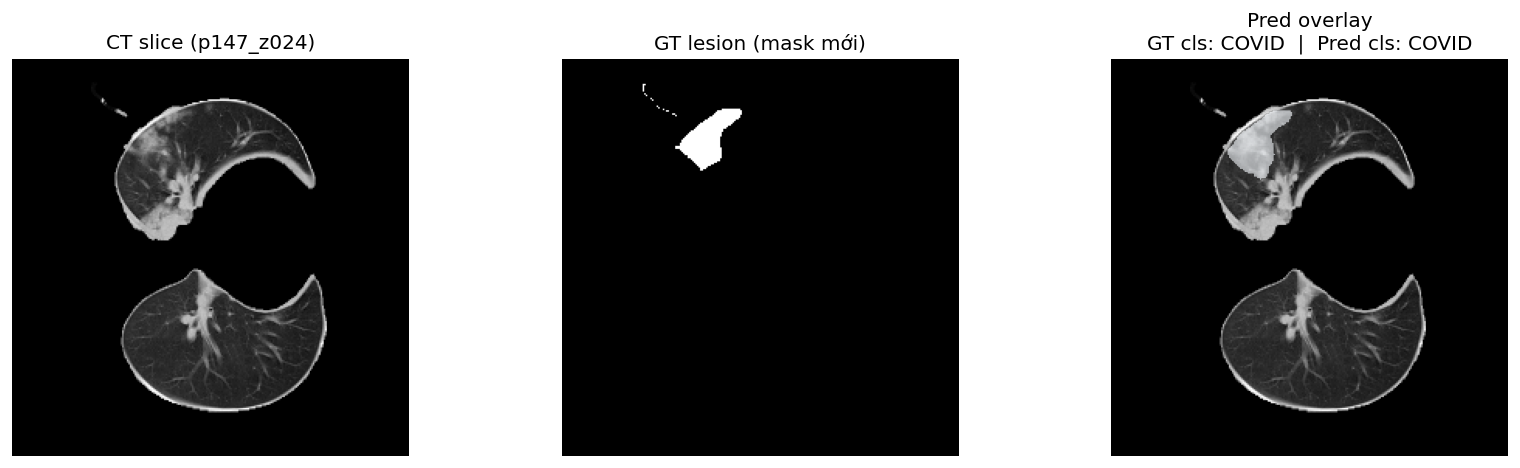

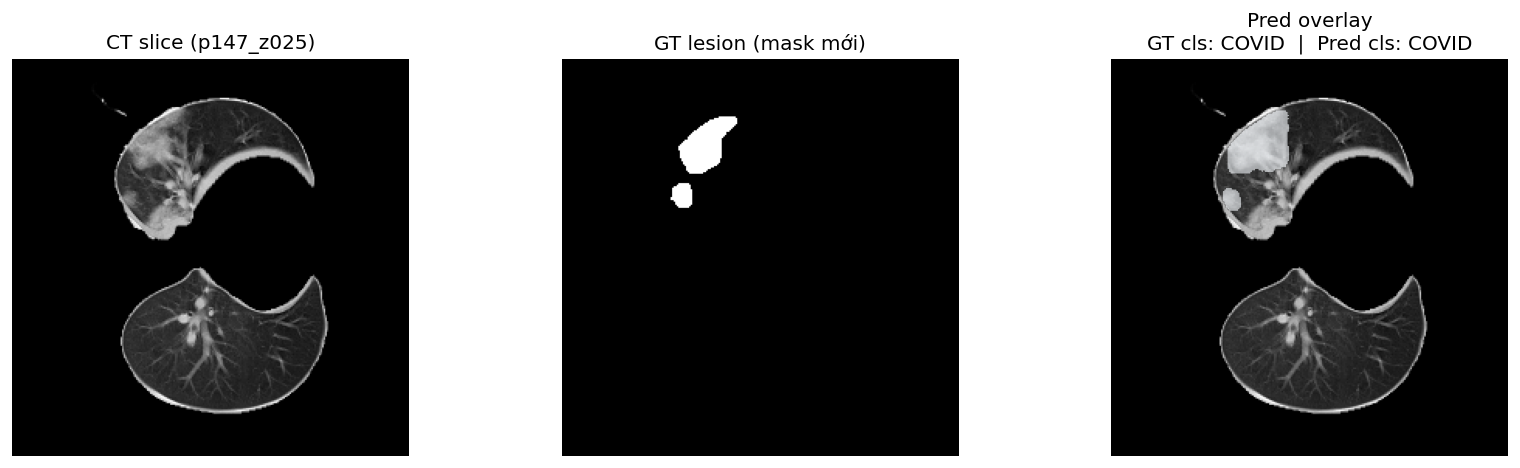

In [24]:
import cv2

# ---- chọn case cần visualize (sửa chuỗi này) ----
CASE_ID = "p147"   # ví dụ; đổi sang case khác nếu muốn

# Lấy danh sách slice_id thuộc case đó và sort theo thứ tự z
sids_case = case_to_slices.get(CASE_ID, [])
if len(sids_case) == 0:
    raise ValueError(f"Không tìm thấy case_id = {CASE_ID} trong test_set")

# sort theo chỉ số z_index trong meta
sids_case = sorted(
    sids_case,
    key=lambda sid: int(test_set.meta[sid]["slice_idx1"])
)

print(f"Case {CASE_ID} có {len(sids_case)} slices trong test.")
print("Một vài slice đầu:", sids_case[:10])

# Chọn một dải slice để vẽ (vd lấy 5 slice giữa)
n_show = 5
mid = len(sids_case) // 2
start = max(0, mid - n_show // 2)
sids_show = sids_case[start:start + n_show]
print("Các slice sẽ vẽ:", sids_show)

cls_names = {0: "NORMAL", 1: "COVID"}


def run_model_on_slice_id(sid: str):
    """Lấy sample theo slice_id, chạy qua model, trả về img, gt_mask, pred_mask, gt_label, pred_label."""
    # tìm index trong dataset
    idx = test_set.slice_ids.index(sid)
    sample = test_set[idx]

    img   = sample["image"].unsqueeze(0).to(device)   # [1,1,H,W]
    mask  = sample["mask"].numpy()[0]                 # [H,W], 0/1
    label = int(sample["label"].item())

    with torch.no_grad():
        pred_seg, pred_cls = model(img)
        pred_seg_np = pred_seg.cpu().numpy()[0, 0]    # [H,W], prob 0-1
        pred_cls_np = pred_cls.cpu().numpy()[0]       # [2]

    pred_mask_bin = (pred_seg_np > 0.5).astype(np.uint8)
    pred_label = int(pred_cls_np.argmax())

    img_np = sample["image"].numpy()[0]               # [H,W], 0-1

    return img_np, mask, pred_mask_bin, label, pred_label


for sid in sids_show:
    img_np, gt_mask, pred_mask, gt_label, pred_label = run_model_on_slice_id(sid)

    plt.figure(figsize=(14, 4))

    # 1) CT slice
    plt.subplot(1, 3, 1)
    plt.imshow(img_np, cmap="gray")
    plt.title(f"CT slice ({sid})")
    plt.axis("off")

    # 2) GT lesion (mask mới)
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("GT lesion (mask mới)")
    plt.axis("off")

    # 3) Overlay prediction
    plt.subplot(1, 3, 3)
    plt.imshow(img_np, cmap="gray")
    plt.imshow(
        np.ma.masked_where(pred_mask == 0, pred_mask),
        cmap="Blues", alpha=0.6
    )
    title_cls = f"Pred overlay\nGT cls: {cls_names[gt_label]}  |  Pred cls: {cls_names[pred_label]}"
    plt.title(title_cls)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### 2.6 Ma trận nhầm lẫn cho phân loại (COVID vs NORMAL)

In [23]:
!pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Saved figure to: d:\Code\PythonProject\Advanced\multi_task_ct\output\multitask_confusion_matrix.png


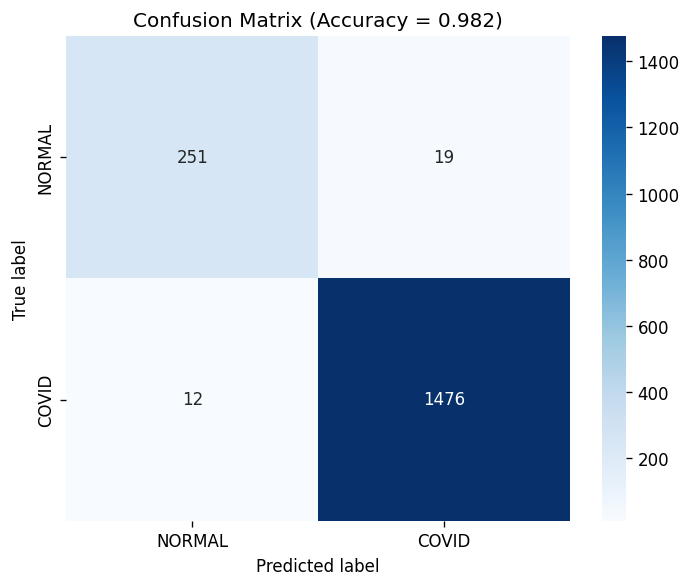

In [25]:
# ============================================================
# VẼ CONFUSION MATRIX DẠNG HÌNH (HEATMAP)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Nhãn lớp để hiển thị
cls_names = ["NORMAL", "COVID"]

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,           # ghi số lên ô
    fmt="d",
    cmap="Blues",
    xticklabels=cls_names,
    yticklabels=cls_names
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion Matrix (Accuracy = {acc:.3f})")
plt.tight_layout()

# Lưu hình nếu muốn
save_path = os.path.join(PROJECT_ROOT, "output", "multitask_confusion_matrix.png")
plt.savefig(save_path, dpi=200)
print("Saved figure to:", save_path)

plt.show()